In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
source=pd.read_csv('personality_datasert.csv')

In [3]:
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [4]:
train.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

Time_spent_Alone 1.1337770367197073
Social_event_attendance -0.2292376022945051
Going_outside -0.367220865398055
Friends_circle_size -0.051806107204632246
Post_frequency -0.058706440773474915


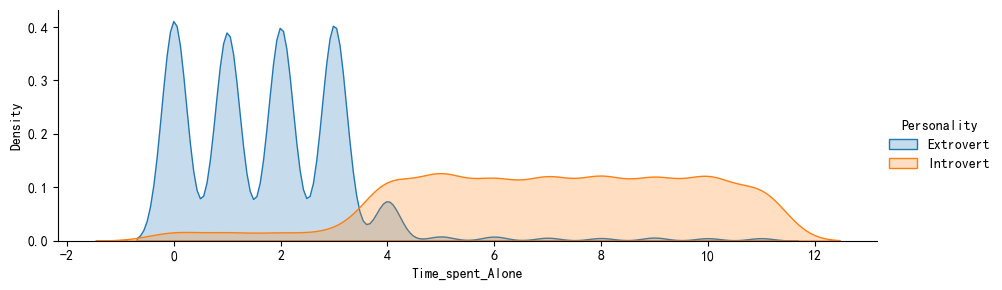

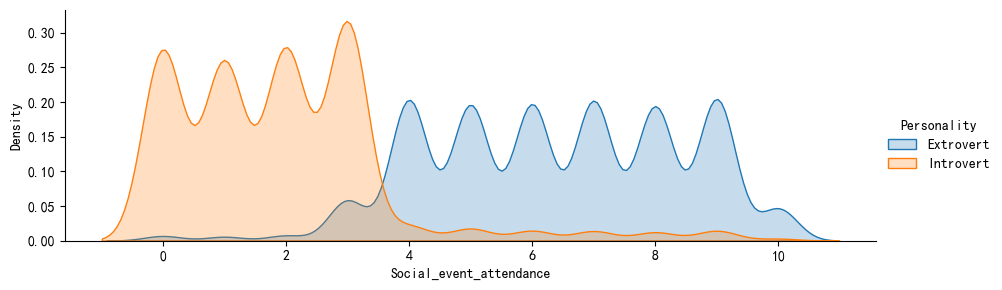

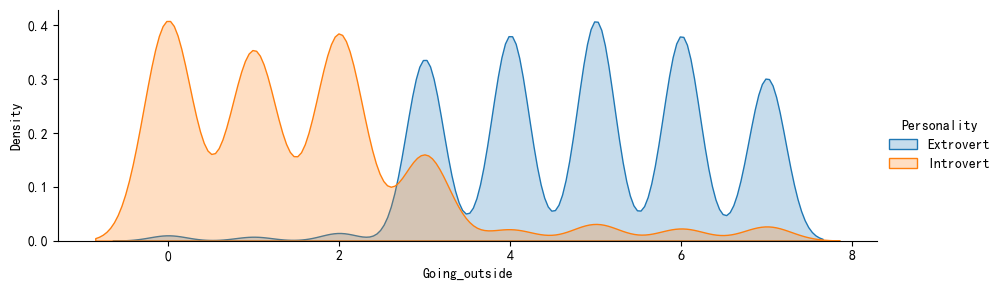

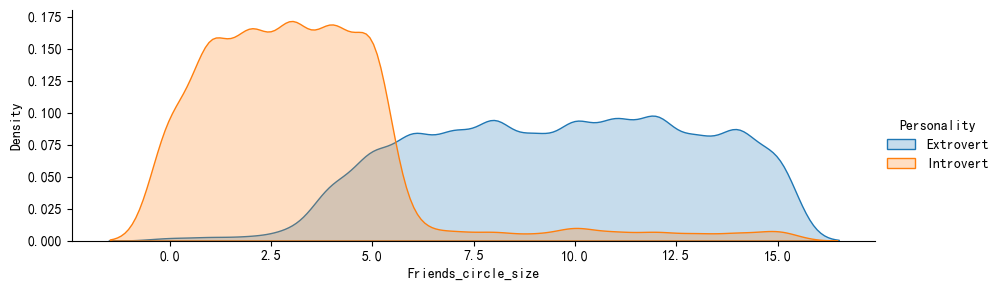

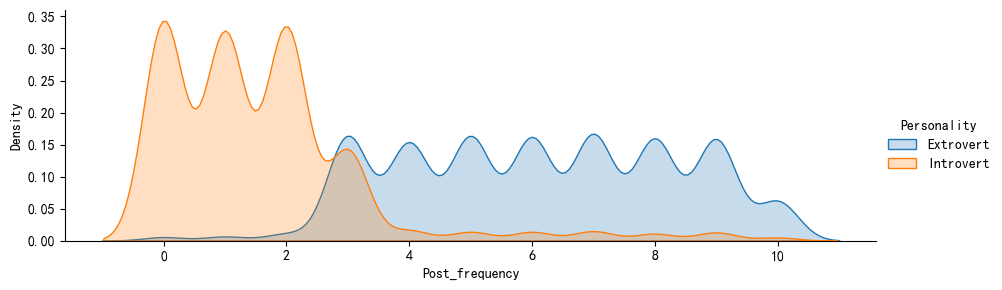

In [5]:
import seaborn as sns
for i in train.columns:
    if train[i].dtype!='object' and i not in ('id','Personality'):
        ageFacet=sns.FacetGrid(train,hue='Personality',aspect=3)
        #作图，选择图形类型
        ageFacet.map(sns.kdeplot,i,shade=True)
        #其他信息：坐标轴范围、标签等
        ageFacet.add_legend()
        print(i,train[i].skew())

In [6]:
n=len(train)
full=pd.concat([train,test], ignore_index=True)
full['Stage_fear'] = full['Stage_fear'].map({'No':0, 'Yes':1})
full['Drained_after_socializing'] = full['Drained_after_socializing'].map({'No':0, 'Yes':1})
full['Personality'] = full['Personality'].map({'Introvert':0 ,'Extrovert':1})

full.drop(['id'],axis=1,inplace=True)

In [7]:
from lightgbm import LGBMClassifier
x=full.drop('Personality',axis=1)
columns=x.columns
y=full['Personality']
from sklearn.preprocessing import StandardScaler
x=StandardScaler().fit_transform(x)
tx, ty=x[:n], y[:n]
pre=x[n:]

rt = LGBMClassifier(verbose=-1)
rt.fit(tx, ty)
print(rt.score(tx,ty))
ans = rt.predict(pre)
full['Personality'][n:]=ans

0.9716583891168215


In [8]:
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 
                   'Going_outside', 'Friends_circle_size', 'Post_frequency']
for feature in numeric_features:
    full[feature] = full.groupby('Personality')[feature].transform(lambda x: x.fillna(x.median()))
    
categorical_features = ['Stage_fear', 'Drained_after_socializing']
for feature in categorical_features:
    full[feature] = full.groupby('Personality')[feature].transform(lambda x: x.fillna(x.mode()[0]))

In [9]:
full.isnull().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [10]:
x=full.drop('Personality',axis=1)
columns=x.columns
y=full['Personality']
from sklearn.preprocessing import StandardScaler
x=StandardScaler().fit_transform(x)
from sklearn.decomposition import PCA
x=PCA().fit_transform(x)
tx, ty=x[:n], y[:n]
pre=x[n:]

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(tx ,ty, test_size=0.2, shuffle=True, stratify=ty)

from sklearn.linear_model import LogisticRegression
lg=LogisticRegression(penalty='l2',class_weight='balanced')
lg.fit(x_train,y_train)
print('acc :')
print(accuracy_score(y_train, lg.predict(x_train)))
print(accuracy_score(y_test, lg.predict(x_test)))

acc :
0.9697010594507052
0.9732793522267207


In [11]:
from sklearn.model_selection import StratifiedKFold
kfold=StratifiedKFold()
s=0
for train_i,test_i in kfold.split(tx,ty):
    lg=LogisticRegression(class_weight='balanced')
    x_train_fold=tx[train_i]
    y_train_fold=ty[train_i]
    x_test_fold=tx[test_i]
    y_test_fold=ty[test_i]

    lg.fit(x_train_fold,y_train_fold)
    s+=accuracy_score(y_test_fold,lg.predict(x_test_fold))
print(s/5)

0.9703629879650114


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
    LogisticRegression(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    LGBMClassifier(),
    XGBClassifier(tree_method='hist'),
]

for m in models:
    m.fit(x_train,y_train)
    print(m.__class__.__name__)
    print('ACC :')
    print(accuracy_score(y_train, m.predict(x_train)))
    print(accuracy_score(y_test, m.predict(x_test)))
    print()

LogisticRegression
ACC :
0.9693636547675282
0.9727395411605938

RandomForestClassifier
ACC :
0.9952088534988865
0.9708502024291498

GradientBoostingClassifier
ACC :
0.9778662527835886
0.9748987854251012

AdaBoostClassifier
ACC :
0.9712531209933194
0.9735492577597841

LGBMClassifier
ACC :
0.9832647277144206
0.9743589743589743

XGBClassifier
ACC :
0.991902287603752
0.9708502024291498



In [92]:
import optuna
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

def rf_search(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 5, 50, step=5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    sk = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        class_weight='balanced',
        n_jobs=-1)
    val = cross_val_score(rf, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

rf_study = optuna.create_study(study_name='rf')
rf_study.optimize(rf_search, timeout=int(60 * 60), n_trials=200)
rf_params = rf_study.best_params

[I 2025-08-29 10:50:46,276] A new study created in memory with name: rf
[I 2025-08-29 10:50:55,329] Trial 0 finished with value: -0.9692292244150831 and parameters: {'n_estimators': 300, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'log_loss'}. Best is trial 0 with value: -0.9692292244150831.
[I 2025-08-29 10:50:57,555] Trial 1 finished with value: -0.9713346478840397 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: -0.9713346478840397.
[I 2025-08-29 10:51:16,694] Trial 2 finished with value: -0.9711187088838562 and parameters: {'n_estimators': 900, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: -0.9713346478840397.
[I 2025-08-29 10:51:38,147] Trial 

In [93]:
import optuna
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

def gb_search(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    subsample = trial.suggest_float("subsample", 0.6, 1.0)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    loss = trial.suggest_categorical("loss", ["log_loss", "exponential"])
    sk = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        loss=loss)
    val = cross_val_score(gb, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

gb_study = optuna.create_study(study_name='gb', direction="minimize")
gb_study.optimize(gb_search, timeout=int(60 * 60), n_trials=200)
gb_params = gb_study.best_params

[I 2025-08-29 11:27:20,642] A new study created in memory with name: gb
[I 2025-08-29 11:29:08,220] Trial 0 finished with value: -0.9694451488415339 and parameters: {'n_estimators': 500, 'learning_rate': 0.04291353315784959, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 8, 'subsample': 0.6941155195697688, 'max_features': 'log2', 'loss': 'exponential'}. Best is trial 0 with value: -0.9694451488415339.
[I 2025-08-29 11:29:45,073] Trial 1 finished with value: -0.9732241323528126 and parameters: {'n_estimators': 200, 'learning_rate': 0.011403880649487856, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 3, 'subsample': 0.9972123720526644, 'max_features': 'sqrt', 'loss': 'exponential'}. Best is trial 1 with value: -0.9732241323528126.
[I 2025-08-29 11:30:09,546] Trial 2 finished with value: -0.9730082225000947 and parameters: {'n_estimators': 200, 'learning_rate': 0.010996540994641745, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 0

In [13]:
import optuna
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

def ada_search(trial):
    algorithm = trial.suggest_categorical("algorithm", ['SAMME', 'SAMME.R'])
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=50)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1, log=True)
    sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
    rf = AdaBoostClassifier(algorithm=algorithm,
                            n_estimators=n_estimators,
                            learning_rate=learning_rate)
    val = cross_val_score(rf, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

ada_study = optuna.create_study(study_name='ada', direction="minimize",)
ada_study.optimize(ada_search, timeout=int(60 * 60), n_trials=200)
ada_params = ada_study.best_params

[I 2025-09-02 15:24:02,152] A new study created in memory with name: ada
[I 2025-09-02 15:25:07,503] Trial 0 finished with value: -0.9710648297933737 and parameters: {'algorithm': 'SAMME.R', 'n_estimators': 950, 'learning_rate': 0.3090871606786795}. Best is trial 0 with value: -0.9710648297933737.
[I 2025-09-02 15:25:52,278] Trial 1 finished with value: -0.9712266856708144 and parameters: {'algorithm': 'SAMME.R', 'n_estimators': 650, 'learning_rate': 0.1413925178877713}. Best is trial 1 with value: -0.9712266856708144.
[I 2025-09-02 15:25:58,484] Trial 2 finished with value: -0.9698770851368328 and parameters: {'algorithm': 'SAMME', 'n_estimators': 100, 'learning_rate': 0.4716009038087642}. Best is trial 1 with value: -0.9712266856708144.
[I 2025-09-02 15:27:07,207] Trial 3 finished with value: -0.9701470635385607 and parameters: {'algorithm': 'SAMME.R', 'n_estimators': 1000, 'learning_rate': 0.6739713406916955}. Best is trial 1 with value: -0.9712266856708144.
[I 2025-09-02 15:28:12,4

In [223]:
import optuna
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

def lgbm_search(trial):
    boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "goss"])
    n_estimators = trial.suggest_int("n_estimators", 200, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 5, 100, step=5)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    min_split_gain = trial.suggest_float("min_split_gain", 0.0, 1.0)
    min_child_weight = trial.suggest_float("min_child_weight", 1e-4, 0.01, log=True)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-6, 0.1, log=True),
    reg_lambda = trial.suggest_float("reg_lambda", 1e-6, 0.1, log=True),
    sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
    rf = LGBMClassifier(boosting_type=boosting_type,
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        min_child_samples=min_child_samples,
                        min_child_weight=min_child_weight,
                        min_split_gain=min_split_gain,
                        reg_alpha=reg_alpha,
                        reg_lambda=reg_lambda,
                        class_weight='balanced',
                        verbose = -1)
    val = cross_val_score(rf, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

lgbm_study = optuna.create_study(study_name='lgbm', direction="minimize",)
lgbm_study.optimize(lgbm_search, timeout=int(60 * 60), n_trials=200)
lgbm_params = lgbm_study.best_params

[I 2025-08-28 22:29:27,706] A new study created in memory with name: lgbm
[I 2025-08-28 22:29:29,417] Trial 0 finished with value: -0.9690672519477795 and parameters: {'boosting_type': 'goss', 'n_estimators': 700, 'max_depth': 40, 'learning_rate': 0.045094159242127264, 'min_child_samples': 33, 'min_split_gain': 0.17600400765600555, 'min_child_weight': 0.0017950999129653885, 'reg_alpha': 0.007861620629024504, 'reg_lambda': 0.0015010889322169673}. Best is trial 0 with value: -0.9690672519477795.
[I 2025-08-28 22:29:30,087] Trial 1 finished with value: -0.9707948659653786 and parameters: {'boosting_type': 'goss', 'n_estimators': 400, 'max_depth': 75, 'learning_rate': 0.07063828760207211, 'min_child_samples': 87, 'min_split_gain': 0.8703362996161998, 'min_child_weight': 0.0013558312780224267, 'reg_alpha': 0.0003157485128468647, 'reg_lambda': 0.002873967285098679}. Best is trial 1 with value: -0.9707948659653786.
[I 2025-08-28 22:29:31,372] Trial 2 finished with value: -0.9705249167111164 a

In [64]:
import optuna
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

def xgb_search(trial):
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1)
    gamma = trial.suggest_float('gamma', 1, 10, step=0.5)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    max_depth = trial.suggest_int('max_depth', 5, 30, step=1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 15, step=1)
    n_estimators = trial.suggest_int('n_estimators', 200, 1000, step=100)
    subsample = trial.suggest_float('subsample', 0.6, 1.0, step=0.1)
    sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
    xgb = XGBClassifier(objective = 'binary:logistic',
                        tree_method='hist',
                        colsample_bytree = colsample_bytree, 
                        gamma = gamma, 
                        learning_rate = learning_rate, 
                        max_depth = max_depth, 
                        min_child_weight = min_child_weight, 
                        n_estimators = n_estimators, 
                        subsample = subsample)
    val = cross_val_score(xgb, tx, ty, scoring='accuracy', cv=sk).mean()
    return -val

xgb_study = optuna.create_study(study_name='xgb', direction="minimize")
xgb_study.optimize(xgb_search, timeout=int(60 * 60), n_trials=200)
xgb_params = xgb_study.best_params

[I 2025-08-29 08:06:03,084] A new study created in memory with name: xgb
[I 2025-08-29 08:06:03,616] Trial 0 finished with value: -0.9709027553099396 and parameters: {'colsample_bytree': 1.0, 'gamma': 10.0, 'learning_rate': 0.0755861247840566, 'max_depth': 12, 'min_child_weight': 13, 'n_estimators': 400, 'subsample': 0.7}. Best is trial 0 with value: -0.9709027553099396.
[I 2025-08-29 08:06:04,530] Trial 1 finished with value: -0.9698231186039529 and parameters: {'colsample_bytree': 0.8, 'gamma': 8.0, 'learning_rate': 0.00764054300235735, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 400, 'subsample': 0.6}. Best is trial 0 with value: -0.9709027553099396.
[I 2025-08-29 08:06:04,910] Trial 2 finished with value: -0.9703088902685357 and parameters: {'colsample_bytree': 1.0, 'gamma': 8.5, 'learning_rate': 0.0037012867622766323, 'max_depth': 8, 'min_child_weight': 13, 'n_estimators': 200, 'subsample': 0.6}. Best is trial 0 with value: -0.9709027553099396.
[I 2025-08-29 08:06:06,3

In [14]:
ada_params

{'algorithm': 'SAMME.R',
 'n_estimators': 600,
 'learning_rate': 0.1757745137178525}

In [ ]:
rf_params={'n_estimators': 700,
 'max_depth': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'bootstrap': False,
 'criterion': 'log_loss'}

gb_params={'n_estimators': 200,
 'learning_rate': 0.011645659481903527,
 'max_depth': 10,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'subsample': 0.8871399414207667,
 'max_features': 'sqrt',
 'loss': 'exponential'}

ada_params={'algorithm': 'SAMME.R',
 'n_estimators': 600,
 'learning_rate': 0.1757745137178525}

lgbm_params={'boosting_type': 'gbdt',
 'n_estimators': 300,
 'max_depth': 95,
 'learning_rate': 0.033370693439199434,
 'min_child_samples': 5,
 'min_split_gain': 0.8555901887366958,
 'min_child_weight': 0.00040025976265403495,
 'reg_alpha': 1.5302867519357278e-06,
 'reg_lambda': 0.00015000074144467002}

xgb_params={'colsample_bytree': 1.0,
            'gamma': 2.0,
            'learning_rate': 0.007358235513383234, 
            'max_depth': 26, 
            'min_child_weight': 1, 
            'n_estimators': 900, 
            'subsample': 0.8}

In [98]:
def hill_climbing(x, y, x_test):
    # 初始化得分字典，用于存储每个模型的准确率得分
    scores = {}

    # 遍历x列标签（各模型）
    for col in x.columns:
        # 将概率预测转换为类别预测（假设二分类，阈值0.5）
        y_pred = (x[col] >= 0.5).astype(int)
        # 计算各模型的准确率
        scores[col] = accuracy_score(y, y_pred)

    # 根据准确率对模型进行排序，得分高的排在前面
    scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

    # 根据准确率得分高低重新排列x和x_test的列顺序
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    # 停止标志，控制爬山算法的终止条件
    STOP = False

    # 取出得分最高的模型作为初始最优模型
    current_best_ensemble = x.iloc[:, 0]
    current_best_test_preds = x_test.iloc[:, 0]

    # 除最优模型外的其他模型
    MODELS = x.iloc[:, 1:]

    # 权重空间，用于尝试不同的权重值
    weight_range = np.arange(-0.5, 0.51, 0.01)

    # 计算最优模型准确率得分的历史
    best_preds = (current_best_ensemble >= 0.5).astype(int)
    history = [accuracy_score(y, best_preds)]
    j = 0

    while not STOP:
        j += 1
        # 计算当前最优集成模型的准确率
        current_preds = (current_best_ensemble >= 0.5).astype(int)
        potential_new_best_cv_score = accuracy_score(y, current_preds)
        k_best, wgt_best = None, None

        # 遍历每个模型以及权重空间，寻找最优的组合
        for k in MODELS.columns:
            for wgt in weight_range:
                # 创建新的集成预测（概率）
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                
                # 转换为类别预测
                ensemble_preds = (potential_ensemble >= 0.5).astype(int)
                cv_score = accuracy_score(y, ensemble_preds)

                # 如果当前组合的准确率高于历史最优，更新最优组合
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            # 更新最优模型和测试集预测（保持概率形式）
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]

            # 从可用模型中移除已选模型
            MODELS = MODELS.drop(k_best, axis=1)

            # 如果已经没有其他可用模型，则停止
            if MODELS.shape[1] == 0:
                STOP = True

            # 记录当前最优得分
            current_final_preds = (current_best_ensemble >= 0.5).astype(int)
            history.append(accuracy_score(y, current_final_preds))
        else:
            # 如果无法找到更好的组合，则停止
            STOP = True

    # 返回最终得到的集成模型的预测结果（概率形式）
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds

    return [hill_ens_pred_1, hill_ens_pred_2, history]

In [99]:
# 初始化交叉检验分数，初始化预测标签
ens_cv_scores, ens_preds = list(), list()
# 初始化hill交叉检验分数，初始化hill预测标签
hill_ens_cv_scores, hill_ens_preds =  list(), list()

# 重复k折交叉验证
sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)

# 遍历每折数据
for i, (train_idx, test_idx) in enumerate(sk.split(tx, ty)):
    
    # 划分训练测试集
    X_train, X_test = tx[train_idx], tx[test_idx]
    Y_train, Y_test = ty[train_idx], ty[test_idx]
    print('----------------------------------------------------------')
    
    #----------------------------------------------------------------------------
    # 训练RF模型
    RF_md = RandomForestClassifier(class_weight='balanced',
                                   n_jobs=-1,
                                   **rf_params).fit(X_train, Y_train)
    
    # 得到测试集预测概率和类别
    rf_pred_prob = RF_md.predict_proba(X_test)[:, 1]
    rf_pred_class = RF_md.predict(X_test)
    # 计算准确率分数
    rf_score = accuracy_score(Y_test, rf_pred_class)
    # 得到测试集预测概率
    rf_pred_test = RF_md.predict_proba(pre)[:, 1]

    #----------------------------------------------------------------------------
    # 训练GB模型
    GB_md = GradientBoostingClassifier(**gb_params).fit(X_train, Y_train)
    
    # 得到测试集预测概率和类别
    gb_pred_prob = GB_md.predict_proba(X_test)[:, 1]
    gb_pred_class = GB_md.predict(X_test)
    # 计算准确率分数
    gb_score = accuracy_score(Y_test, gb_pred_class)
    # 得到测试集预测概率
    gb_pred_test = GB_md.predict_proba(pre)[:, 1]

    #----------------------------------------------------------------------------
    # 训练LGBM模型
    LGBM_md = LGBMClassifier(verbose=-1,
                             class_weight='balanced',
                             **lgbm_params).fit(X_train, Y_train)
    
    # 得到测试集预测概率和类别
    lgb_pred_prob = LGBM_md.predict_proba(X_test)[:, 1]
    lgb_pred_class = LGBM_md.predict(X_test)
    # 计算准确率分数
    lgb_score = accuracy_score(Y_test, lgb_pred_class)
    # 得到测试集预测概率
    lgb_pred_test = LGBM_md.predict_proba(pre)[:, 1]
    
    #----------------------------------------------------------------------------
    # 训练XGB模型
    XGB_md = XGBClassifier(objective = 'binary:logistic',
                           tree_method='hist',
                           **xgb_params).fit(X_train, Y_train)
    # 得到验证集预测概率和类别
    xgb_pred_prob = XGB_md.predict_proba(X_test)[:, 1]
    xgb_pred_class = XGB_md.predict(X_test)
    # 计算准确率分数
    xgb_score = accuracy_score(Y_test, xgb_pred_class)
    # 得到测试集预测概率
    xgb_pred_test = XGB_md.predict_proba(pre)[:, 1]
    
    #--------------------------------------------------------------------------
    # 简单组合模型 - 使用投票法
    # 各模型验证集预测类别投票
    ens_pred_class = np.round((rf_pred_class + gb_pred_class + lgb_pred_class + xgb_pred_class) / 4).astype(int)
    # 计算准确率分数
    ens_score_fold = accuracy_score(Y_test, ens_pred_class)
    # 记录组合模型验证集准确率
    ens_cv_scores.append(ens_score_fold)
    
    # 对于测试集，使用概率平均然后转换为类别
    ens_pred_test_prob = (rf_pred_test+ gb_pred_test + lgb_pred_test + xgb_pred_test) / 4
    ens_pred_test_class = (ens_pred_test_prob >= 0.5).astype(int)
    # 记录组合模型测试集预测类别
    ens_preds.append(ens_pred_test_class)
    
    print('Fold', i, '==> Average Ensemble accuracy score is ==>', ens_score_fold)
    
    #--------------------------------------------------------------------------
    # 加权组合模型 - 使用修改后的hill_climbing_accuracy函数
    x = pd.DataFrame({'RF': rf_pred_prob,
                      'GB': gb_pred_prob,
                      'LGBM': lgb_pred_prob,
                      'XGB': xgb_pred_prob})
    y = Y_test
        
    x_test = pd.DataFrame({'RF': rf_pred_test,
                           'GB': gb_pred_test,
                           'LGBM': lgb_pred_test,
                           'XGB': xgb_pred_test})
    
    # 使用修改后的hill_climbing_accuracy函数
    hill_results = hill_climbing(x, y, x_test)
    
    # 将概率预测转换为类别预测
    hill_pred_class = (hill_results[0] >= 0.5).astype(int)
    hill_ens_score_fold = accuracy_score(y, hill_pred_class)
    hill_ens_cv_scores.append(hill_ens_score_fold)
    
    # 将测试集概率预测转换为类别预测
    hill_test_class = (hill_results[1] >= 0.5).astype(int)
    hill_ens_preds.append(hill_test_class)

    print('Fold', i, '==> Hill Climbing Ensemble accuracy score is ==>', hill_ens_score_fold)

# 计算平均准确率
avg_ens_accuracy = np.mean(ens_cv_scores)
avg_hill_ens_accuracy = np.mean(hill_ens_cv_scores)

print('==========================================================')
print('Average Ensemble Mean Accuracy:', avg_ens_accuracy)
print('Hill Climbing Ensemble Mean Accuracy:', avg_hill_ens_accuracy)

----------------------------------------------------------
Fold 0 ==> Average Ensemble accuracy score is ==> 0.9713900134952766
Fold 0 ==> Hill Climbing Ensemble accuracy score is ==> 0.9732793522267207
----------------------------------------------------------
Fold 1 ==> Average Ensemble accuracy score is ==> 0.9711201079622133
Fold 1 ==> Hill Climbing Ensemble accuracy score is ==> 0.9732793522267207
----------------------------------------------------------
Fold 2 ==> Average Ensemble accuracy score is ==> 0.970310391363023
Fold 2 ==> Hill Climbing Ensemble accuracy score is ==> 0.9721997300944669
----------------------------------------------------------
Fold 3 ==> Average Ensemble accuracy score is ==> 0.9751686909581646
Fold 3 ==> Hill Climbing Ensemble accuracy score is ==> 0.9759784075573549
----------------------------------------------------------
Fold 4 ==> Average Ensemble accuracy score is ==> 0.9762419006479481
Fold 4 ==> Hill Climbing Ensemble accuracy score is ==> 0.977

In [100]:
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)
ans_df=pd.DataFrame({'id':test['id'],'Personality':ens_preds_test.map(lambda x:'Introvert' if x==0 else 'Extrovert')})
ans_df.to_csv('Avereage_Ensemble_Baseline_submission.csv',index=False)

ens_preds_test = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)
ans_df=pd.DataFrame({'id':test['id'],'Personality':ens_preds_test.map(lambda x:'Introvert' if x==0 else 'Extrovert')})
ans_df.to_csv('Hill_Ensemble_Baseline_submission.csv',index=False)